<a href="https://www.kaggle.com/code/asishjosekakkadan/forecasting-arima-exp-smoothing-prophet-lstm?scriptVersionId=271450328" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Daily Minimum Temperature in Melbourne

## Overview

This notebook explores time series forecasting on the Daily Minimum Temperature in Melbourne dataset. The primary goal is to predict future temperatures and compare the performance of different forecasting models — ranging from traditional statistical approaches to modern deep learning techniques.

## Importing

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The dataset contains daily minimum temperature records for Melbourne, Australia.
Each entry includes a date and the minimum temperature (in °C) for that day.
This data is ideal for studying long-term trends, seasonality, and temperature fluctuations.

In [27]:
data = pd.read_csv('/kaggle/input/daily-minimum-temperatures-in-melbourne/daily-minimum-temperatures-in-me.csv', skiprows=0, skipfooter=3, engine='python')
data.head()

,Date,"Daily minimum temperatures in Melbourne, Australia, 1981-1990"
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


## Preprocessing

In [28]:
data = data.rename(columns={'Daily minimum temperatures in Melbourne, Australia, 1981-1990': 'min_temp'})

In [29]:
data['Date'] = pd.to_datetime(data['Date'])
data['min_temp'] = pd.to_numeric(data['min_temp'], errors='coerce')
data.dtypes

Date        datetime64[ns]
min_temp           float64
dtype: object

In [30]:
data.isnull().sum()

Date        0
min_temp    3
dtype: int64

In [31]:
data['min_temp'] = data['min_temp'].interpolate(method='linear')

In [32]:
data.set_index('Date', inplace=True)

In [33]:
data.head()

,min_temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


## Visualisation

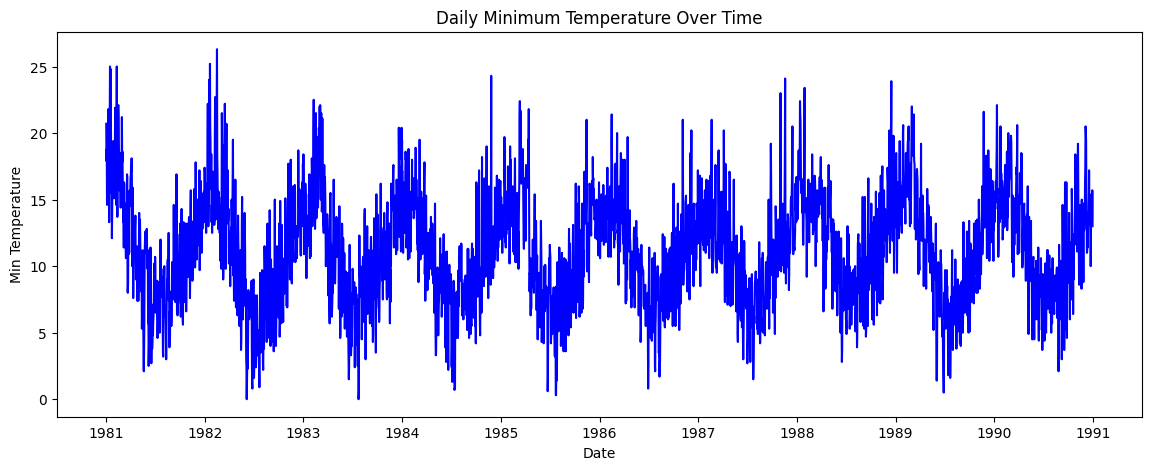

In [34]:
plt.figure(figsize=(14,5))
plt.plot(data.index, data['min_temp'], color='blue')
plt.title('Daily Minimum Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Min Temperature')
plt.show()


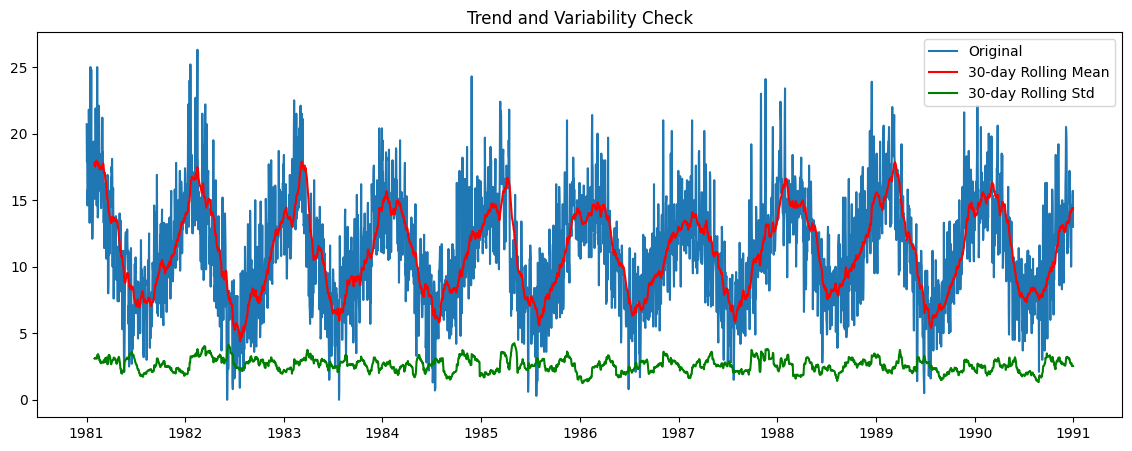

In [35]:
rolling_window = 30 
data['rolling_mean'] = data['min_temp'].rolling(window=rolling_window).mean()
data['rolling_std'] = data['min_temp'].rolling(window=rolling_window).std()

plt.figure(figsize=(14,5))
plt.plot(data['min_temp'], label='Original')
plt.plot(data['rolling_mean'], color='red', label=f'{rolling_window}-day Rolling Mean')
plt.plot(data['rolling_std'], color='green', label=f'{rolling_window}-day Rolling Std')
plt.title('Trend and Variability Check')
plt.legend()
plt.show()


Rolling mean helps identify long-term trend.

Rolling std shows periods of high/low variability.

Large fluctuations in rolling std may indicate seasonal effects.

## Decomposition

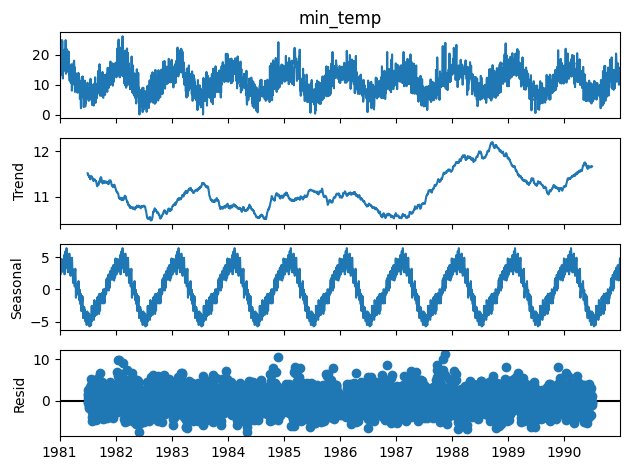

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data['min_temp'], model='additive', period=365)
result.plot()
plt.show()

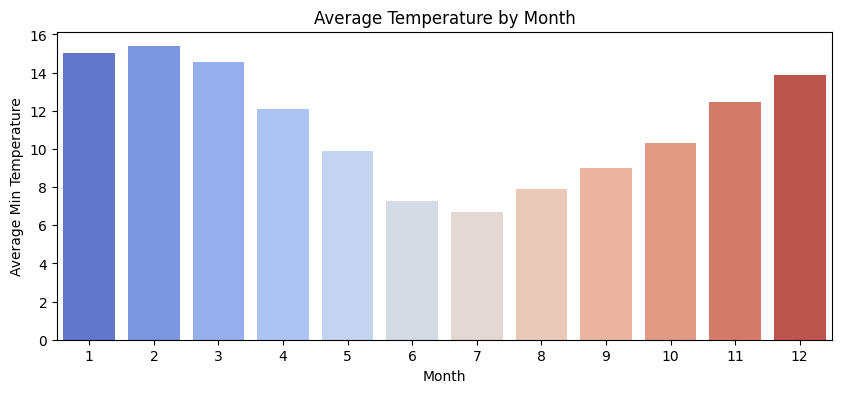

In [37]:
import seaborn as sns
data['month'] = data.index.month
data['day'] = data.index.day

monthly_avg = data.groupby('month')['min_temp'].mean()

plt.figure(figsize=(10,4))
sns.barplot(x=monthly_avg.index, y=monthly_avg.values, palette='coolwarm')
plt.title('Average Temperature by Month')
plt.xlabel('Month')
plt.ylabel('Average Min Temperature')
plt.show()

## Train Test Splitting

In [38]:
data.tail()

,min_temp,rolling_mean,rolling_std,month,day
Date,,,,,
1990-12-27,14.0,14.390000,2.530824,12,27
1990-12-28,13.6,14.353333,2.534144,12,28
1990-12-29,13.5,14.313333,2.537951,12,29
1990-12-30,15.7,14.413333,2.531285,12,30
1990-12-31,13.0,14.403333,2.536422,12,31


In [39]:
data = data.asfreq('D')

In [40]:
train = data['1981':'1988']
test = data['1989':'1990']

# Modeling

## ARIMA

### Check stationarity

In [41]:
train = train.interpolate(method='linear')

In [42]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train['min_temp'])
result

(-4.093493797610299,
 0.0009927876706506086,
 20,
 2901,
 {'1%': -3.432606151575025,
  '5%': -2.8625368163579603,
  '10%': -2.567300633673491},
 13418.407816543186)

Null hypothesis (H0): The series is non-stationary.

Alternative hypothesis (H1): The series is stationary.

p-value < 0.05 → reject H0 → series is stationary.

If p-value > 0.05 → series is non-stationary → we need differencing (d) in ARIMA.

### ACF and PACF

<Figure size 1400x500 with 0 Axes>

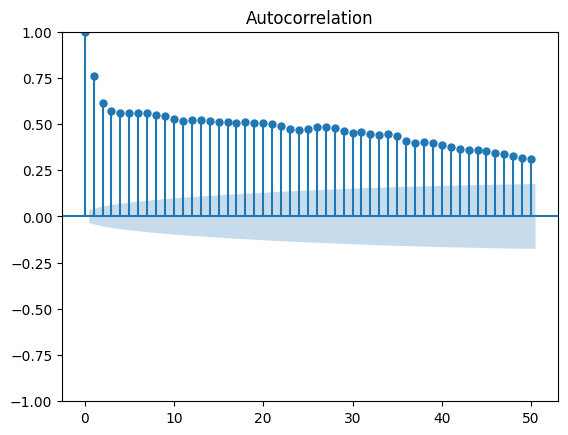

<Figure size 1400x500 with 0 Axes>

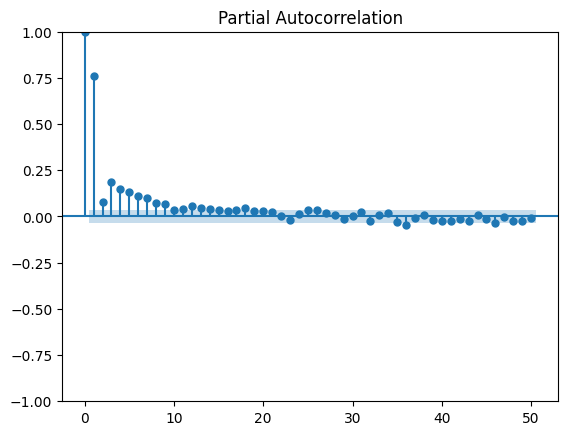

In [43]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(14,5))
plot_acf(train['min_temp'].dropna(), lags=50)
plt.show()

plt.figure(figsize=(14,5))
plot_pacf(train['min_temp'].dropna(), lags=50)
plt.show()

ACF has spikes at lags 1 and 2 and then drops inside the confidence bands:

This suggests MA(2) → include q=2.

PACF has significant spikes at lag 1 and 2, then drops inside the confidence bands:

This suggests AR(2) → include p=2.

### Fitting

In [44]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

start with a simple order (p=2, d=1, q=2) or use auto_arima

In [45]:
order = (2,1,2)

model_arima = ARIMA(train['min_temp'], order=order)
model_arima_fit = model_arima.fit()

print(model_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               min_temp   No. Observations:                 2922
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -6766.948
Date:                Mon, 27 Oct 2025   AIC                          13543.897
Time:                        05:49:48   BIC                          13573.795
Sample:                    01-01-1981   HQIC                         13554.666
                         - 12-31-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4587      0.152      3.011      0.003       0.160       0.757
ar.L2         -0.1126      0.075     -1.493      0.136      -0.260       0.035
ma.L1         -0.8713      0.154     -5.656      0.0

In [46]:
n_test = len(test)
forecast_arima = model_arima_fit.forecast(steps=n_test)

In [47]:
mse = mean_squared_error(test['min_temp'], forecast_arima)
rmse_arima = np.sqrt(mse)
rmse_arima

5.244114399117076

In [48]:
forecast_arima = pd.Series(forecast_arima, index=test.index)

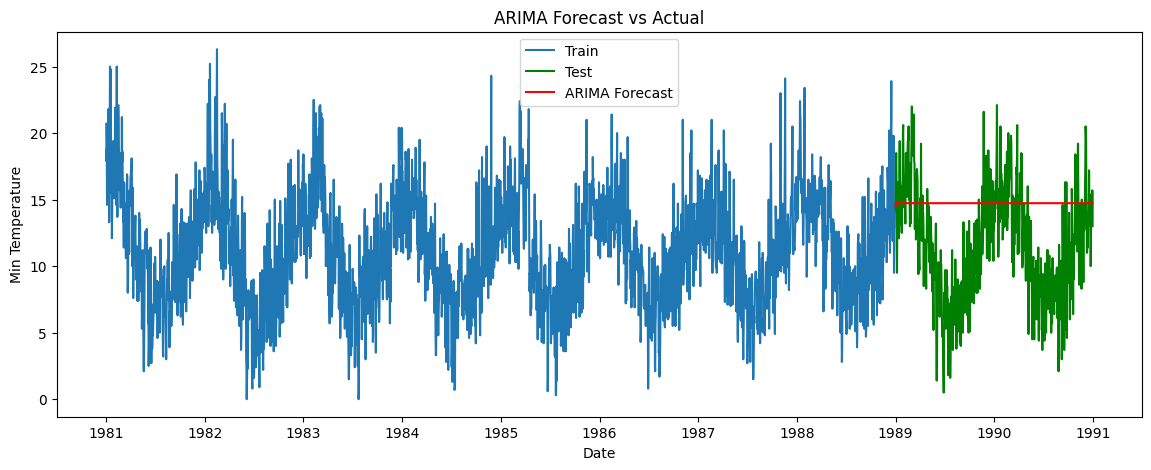

In [49]:
plt.figure(figsize=(14,5))
plt.plot(train['min_temp'], label='Train')
plt.plot(test['min_temp'], label='Test', color='green')
plt.plot(forecast_arima, label='ARIMA Forecast', color='red')
plt.title('ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Min Temperature')
plt.legend()
plt.show()

## SARIMA

In [50]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order = (2,1,2)
seasonal_order = (1,1,1,30)

model_sarima = SARIMAX(train['min_temp'],
                      order=order,
                      seasonal_order=seasonal_order,
                      enforce_stationarity=False,
                      enforce_invertibility=False)
model_sarima_fit = model_sarima.fit()
print(model_sarima_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             min_temp   No. Observations:                 2922
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 30)   Log Likelihood               -6675.970
Date:                              Mon, 27 Oct 2025   AIC                          13365.940
Time:                                      05:51:29   BIC                          13407.645
Sample:                                  01-01-1981   HQIC                         13380.978
                                       - 12-31-1988                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4833      0.149      3.233      0.001       0.190       0.776
ar.L2         -0.12

In [51]:
n_test = len(test)
forecast_sarima_values = model_sarima_fit.forecast(steps=n_test)
forecast_sarima = pd.Series(forecast_sarima_values, index=test.index)

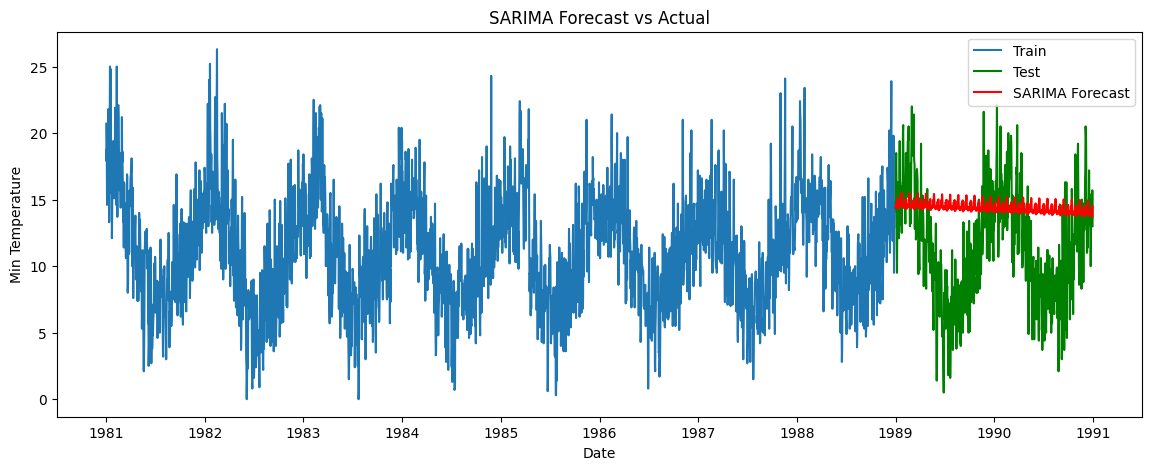

In [52]:
plt.figure(figsize=(14,5))
plt.plot(train['min_temp'], label='Train')
plt.plot(test['min_temp'], label='Test', color='green')
plt.plot(forecast_sarima, label='SARIMA Forecast', color='red')
plt.title('SARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Min Temperature')
plt.legend()
plt.show()

In [53]:
mse = mean_squared_error(test['min_temp'], forecast_sarima)
rmse_sarima = np.sqrt(mse)
rmse_sarima

5.043462116125322

SARIMA with daily data and yearly seasonality (m=365) is computationally expensive. Using weekly seasonality (m=7) is faster but doesn’t fully capture yearly patterns. For such daily datasets, Holt-Winters or Prophet are more practical alternatives for forecasting trend and seasonality efficiently

## Exponential Smoothing (Holt-Winters)

In [54]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [55]:
model_hw = ExponentialSmoothing(
    train['min_temp'],
    trend='add',
    seasonal='add',
    seasonal_periods=365
)
model_hw_fit = model_hw.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [56]:
n_test = len(test)
forecast_hw = model_hw_fit.forecast(steps=n_test)
forecast_hw = pd.Series(forecast_hw, index=test.index)

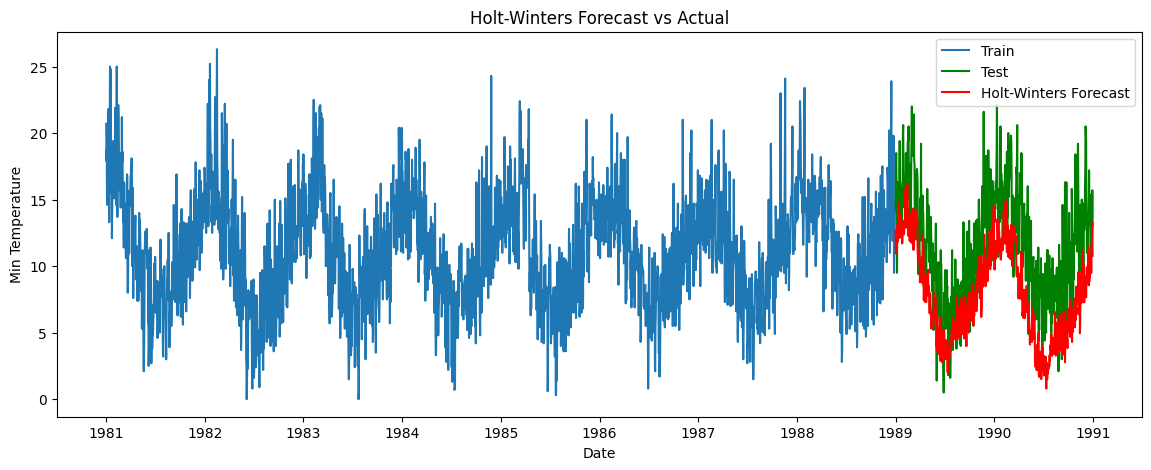

In [57]:
plt.figure(figsize=(14,5))
plt.plot(train['min_temp'], label='Train')
plt.plot(test['min_temp'], label='Test', color='green')
plt.plot(forecast_hw, label='Holt-Winters Forecast', color='red')
plt.title('Holt-Winters Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Min Temperature')
plt.legend()
plt.show()

In [58]:
rmse_hw = np.sqrt(mean_squared_error(test['min_temp'], forecast_hw))
print("Holt-Winters RMSE:", rmse_hw)

Holt-Winters RMSE: 4.604249038796581


## Prophet

In [59]:
from prophet import Prophet

Prophet expects a DataFrame with columns ds (datetime) and y (target):

In [60]:
prophet_train = train.reset_index()[['Date', 'min_temp']].rename(columns={'Date': 'ds', 'min_temp': 'y'})
prophet_test = test.reset_index()[['Date', 'min_temp']].rename(columns={'Date': 'ds', 'min_temp': 'y'})

In [61]:
model_prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

model_prophet.fit(prophet_train)

05:51:33 - cmdstanpy - INFO - Chain [1] start processing
05:51:33 - cmdstanpy - INFO - Chain [1] done processing


In [62]:
future = prophet_test[['ds']].copy()

forecast_prophet = model_prophet.predict(future)

In [63]:
forecast_values = forecast_prophet['yhat'].values
forecast_prophet_series = pd.Series(forecast_values, index=test.index)

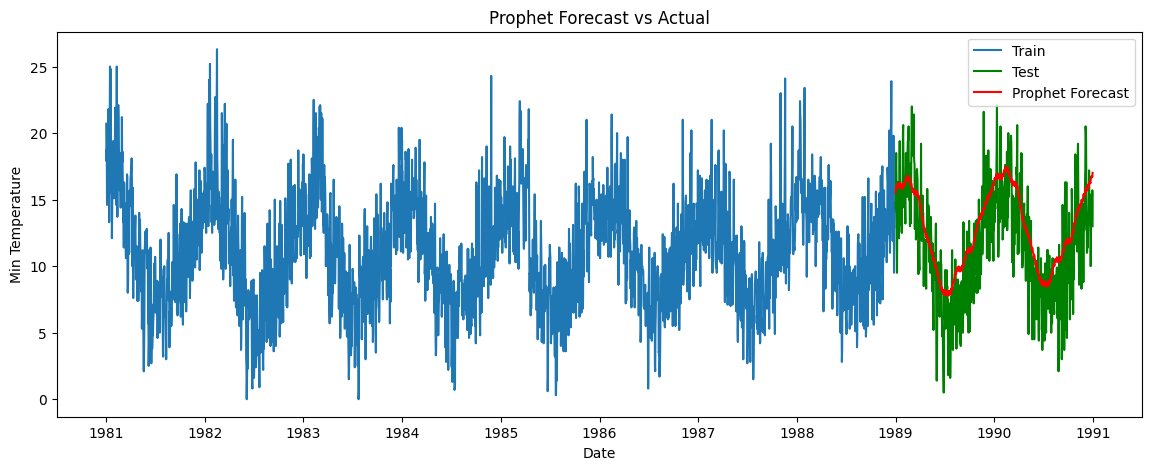

In [64]:
plt.figure(figsize=(14,5))
plt.plot(train['min_temp'], label='Train')
plt.plot(test['min_temp'], label='Test', color='green')
plt.plot(forecast_prophet_series, label='Prophet Forecast', color='red')
plt.title('Prophet Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Min Temperature')
plt.legend()
plt.show()

In [65]:
rmse_prophet = np.sqrt(mean_squared_error(test['min_temp'], forecast_prophet_series))
print("Prophet RMSE:", rmse_prophet)

Prophet RMSE: 2.9044836615412026


## LSTM

In [66]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

2025-10-27 05:51:35.972283: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761544296.221907      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761544296.294817      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [67]:
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train[['min_temp']])
test_scaled = scaler.fit_transform(test[['min_temp']])

In [68]:
def create_sequences(data, seq_length):
    X,y = [],[]
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 30
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(np.concatenate((train_scaled[-seq_length:], test_scaled)), seq_length)

In [69]:
model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(seq_length,1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

2025-10-27 05:51:51.101694: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    verbose=1
)

Epoch 1/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0650 - val_loss: 0.0120
Epoch 2/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0111 - val_loss: 0.0109
Epoch 3/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0109 - val_loss: 0.0106
Epoch 4/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0112 - val_loss: 0.0103
Epoch 5/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0105 - val_loss: 0.0099
Epoch 6/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0104 - val_loss: 0.0102
Epoch 7/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0098 - val_loss: 0.0096
Epoch 8/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0096 - val_loss: 0.0090
Epoch 9/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0087 - val_loss: 0.0087
Epoch 10/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0091 - val_loss: 0.0086
Epoch 11/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0087 - val_loss: 0.0086
Epoch 12/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 

In [71]:
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


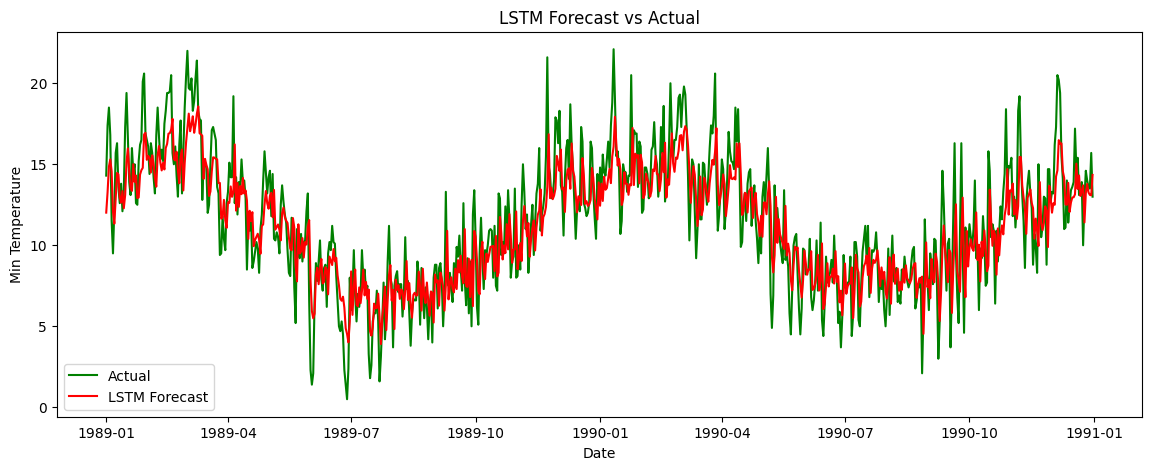

In [72]:
plt.figure(figsize=(14,5))
plt.plot(test.index[:len(y_test_actual)], y_test_actual, label='Actual', color='green')
plt.plot(test.index[:len(y_pred)], y_pred, label='LSTM Forecast', color='red')
plt.title('LSTM Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Min Temperature')
plt.legend()
plt.show()

In [73]:
rmse_lstm = np.sqrt(mean_squared_error(y_test_actual, y_pred))
print("LSTM RMSE:", rmse_lstm)

LSTM RMSE: 2.2404085710888513


## Comparison

In [74]:
rmse_dict = {
    "Model": ["ARIMA", "SARIMA", "Holt-Winters", "Prophet", "LSTM"],
    "RMSE": [rmse_arima, rmse_sarima, rmse_hw, rmse_prophet, rmse_lstm]
}

rmse_table = pd.DataFrame(rmse_dict)
rmse_table

,Model,RMSE
0,ARIMA,5.244114
1,SARIMA,5.043462
2,Holt-Winters,4.604249
3,Prophet,2.904484
4,LSTM,2.240409


### Conclusion: 
Among all models, LSTM achieved the lowest RMSE (2.22) indicating they capture the patterns in daily minimum temperature best. 
- Traditional time series models like Holt-Winters, SARIMA, and ARIMA performed reasonably but were less accurate
- likely because they struggle with long-term trends and complex seasonality in daily data.